*   **Dataset**: *Daily Minimum Temperatures in Melbourne (1981–1990)*

*   **Métrica escolhida**: *RSME* - Penaliza melhor grandes erros (elevando eles ao quadrado), além de ser de fácil interpretabilidade (mesma unidade da variável alvo). Quanto maior o erro, mais crítico ele é, podendo comprometer a agricultura, serviços e etc.






In [2]:

# Instalações e Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Download do Dataset (direto do GitHub)
!wget -O /content/daily-minimum-temperatures.csv https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

# Carregar dados
df = pd.read_csv("/content/daily-minimum-temperatures.csv")
print(df.head())


--2025-09-15 01:17:06--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/content/daily-minimum-temperatures.csv’

/content/daily-mini 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2025-09-15 01:17:06 (4.57 MB/s) - ‘/content/daily-minimum-temperatures.csv’ saved [67921/67921]

         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


In [3]:
# Converter datas
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Temp']].values

# Normalizar
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

# Função para criar janelas (lags)
def create_dataset(dataset, time_step=30):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(data_scaled, time_step)

# Reshape
X = X.reshape(X.shape[0], X.shape[1], 1)

# Dividir em treino e teste (80/20)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [4]:
# Criar modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_data=(X_test,y_test), verbose=1)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0492 - val_loss: 0.0104
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0113 - val_loss: 0.0095
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0115 - val_loss: 0.0093
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0111 - val_loss: 0.0088
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0103 - val_loss: 0.0080
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0089 - val_l

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE Treino: 2.459
RMSE Teste : 2.209


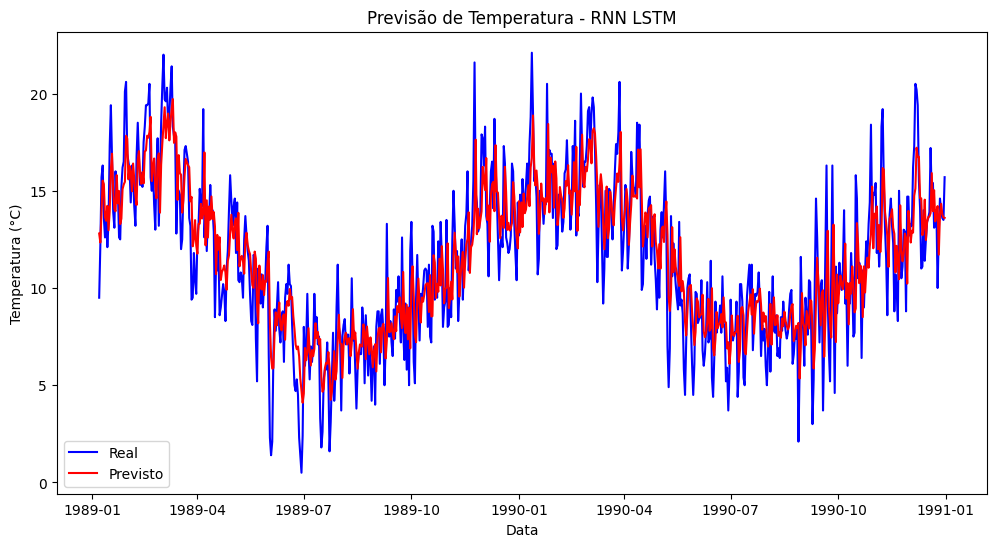

In [5]:
# Previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverter normalização
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])

# RMSE
train_rmse = sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
test_rmse = sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))

print(f"RMSE Treino: {train_rmse:.3f}")
print(f"RMSE Teste : {test_rmse:.3f}")

# Gráfico Real vs Previsto
plt.figure(figsize=(12,6))
plt.plot(df['Date'][-len(y_test):], y_test_inv[0], label="Real", color="blue")
plt.plot(df['Date'][-len(y_test):], test_predict[:,0], label="Previsto", color="red")
plt.title("Previsão de Temperatura - RNN LSTM")
plt.xlabel("Data")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.show()
